In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import plot_tree

In [22]:
file_data = 'ml-100k/u.data'
file_user = 'ml-100k/u.user'
file_film = 'ml-100k/u.item'

ratings_df = pd.read_csv(file_data, sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
user_info = pd.read_csv(file_user, sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip'])
film_info = pd.read_csv(file_film, sep='|', names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 
                                                   'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 
                                                   'Drama', 'Fantasy', 'Film Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'SciFi', 
                                                   'Thriller', 'War', 'Western'], encoding='ISO-8859-1')

# Merge datasets
merged_df = ratings_df.merge(user_info, on='user_id').merge(film_info, left_on='item_id', right_on='movie_id')

# Drop redundant columns
merged_df = merged_df.drop(columns=['release_date', 'unknown', 'movie_id', 'timestamp', 'zip', 'video_release_date', 'IMDb_URL', 'title'])

# Convert text to numerical values with one-hot encoding
merged_df['gender'] = merged_df['gender'].map({'M': 0, 'F': 1})
merged_df = pd.get_dummies(merged_df, columns=['occupation'])

print(merged_df.head())

   user_id  item_id  rating  age  gender  Action  Adventure  Animation  \
0      196      242       3   49       0       0          0          0   
1      186      302       3   39       1       0          0          0   
2       22      377       1   25       0       0          0          0   
3      244       51       2   28       0       0          0          0   
4      166      346       1   47       0       0          0          0   

   Childrens  Comedy  ...  occupation_marketing  occupation_none  \
0          0       1  ...                 False            False   
1          0       0  ...                 False            False   
2          1       1  ...                 False            False   
3          0       0  ...                 False            False   
4          0       0  ...                 False            False   

   occupation_other  occupation_programmer  occupation_retired  \
0             False                  False               False   
1             

In [52]:
# Define features (X) and target (y)
X = merged_df.drop(columns=['rating'])
y = merged_df['rating']

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict ratings
y_pred = rf_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.8176
RMSE: 1.0224


In [41]:
def plot_partial_dependence_age_for_movie(model, X_test, movie_title, age_range=(15, 70)):
    # Find movie ID
    movie_data = film_info[film_info['title'] == movie_title]
    if movie_data.empty:
        print("Movie not found.")
        return

    movie_id = movie_data['movie_id'].values[0]
    
    # Filter movies
    movie_ratings = X_test[X_test['item_id'] == movie_id]

    ages = np.arange(age_range[0], age_range[1] + 1)
    avg_ratings = []

    for age in ages:
        X_movie_modified = movie_ratings.copy()
        X_movie_modified['age'] = age  # Set all user ages to the same value
        y_pred_modified = model.predict(X_movie_modified)
        avg_ratings.append(np.mean(y_pred_modified))

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(ages, avg_ratings, marker='o', linestyle='-', color='b')
    plt.xlabel("Age")
    plt.ylabel("Predicted Rating")
    plt.title(f"Partial Dependence Plot: Age vs. Rating for Movie: {movie_title}")
    plt.grid()
    plt.show()

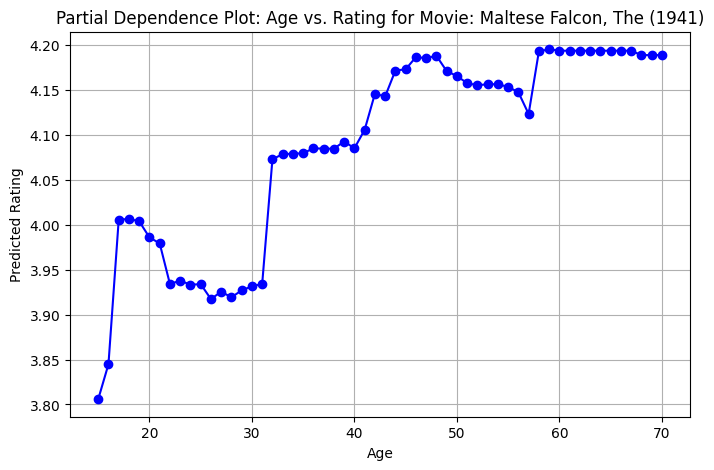

In [53]:
plot_partial_dependence_age_for_movie(rf_model, X_test, movie_title='Maltese Falcon, The (1941)') # some old movie
# plot_partial_dependence_age_for_movie(rf_model, X_test, movie_title='Seven (Se7en) (1995)') # some new movie

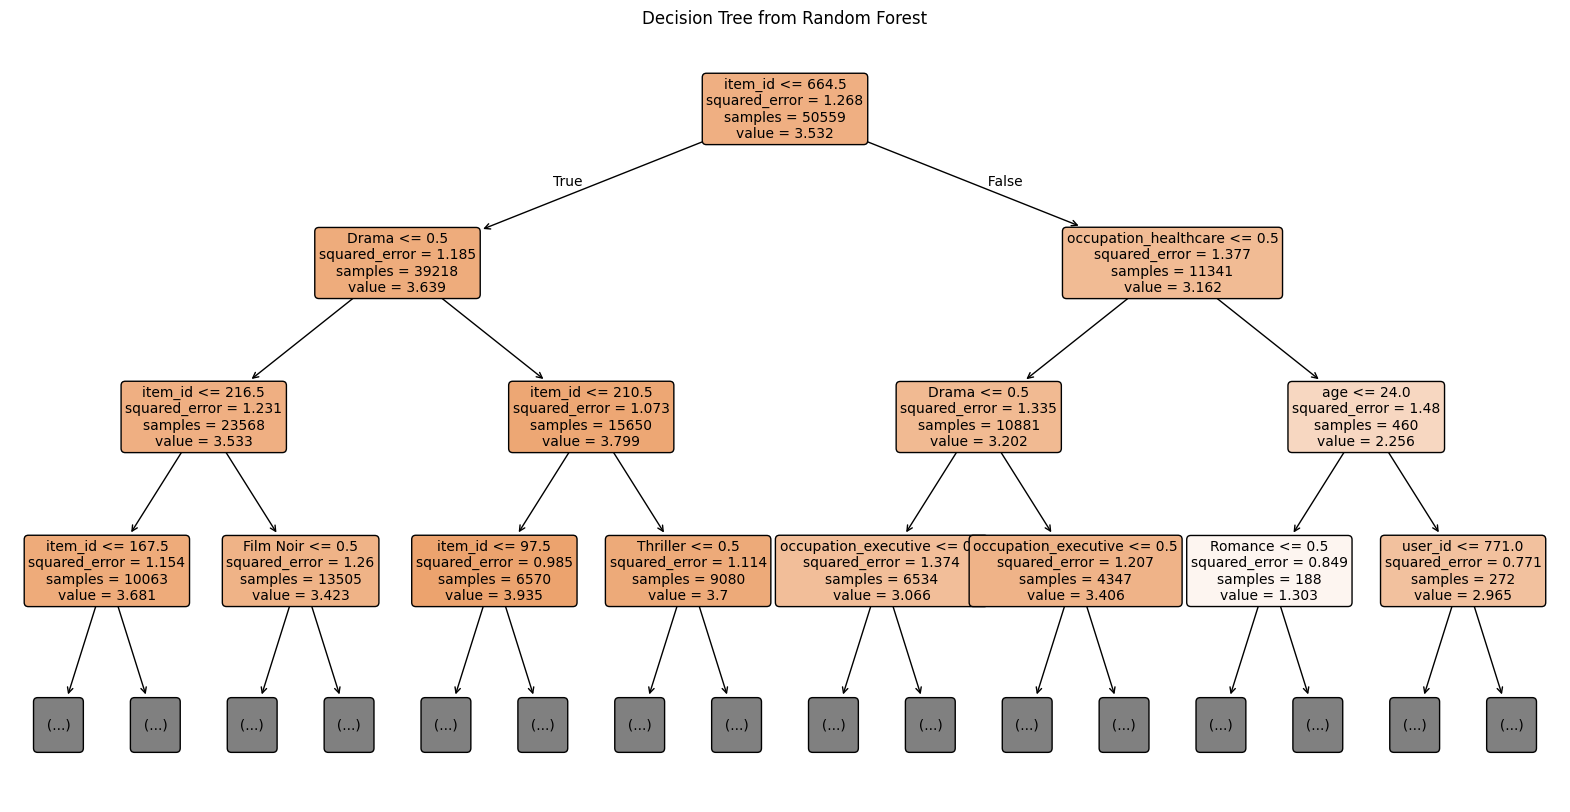

In [54]:
tree_to_plot = rf_model.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, max_depth=3, feature_names=X_test.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()